In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, r2_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from pathlib import Path
import os

In [169]:
CWD = os.path.abspath('')

# Data Observation

In [170]:
def get_data(ds_type: str) -> pd.DataFrame:
    """
    :param ds_type: train / test
    """
    path = Path(CWD).parent / f'data/{ds_type}.csv'
    
    return pd.read_csv(path)

In [171]:
def calculate_nan_values(data: pd.DataFrame) -> pd.DataFrame:
    nan_counts = data.isna().sum()
    nan_counts_percent = (data.isna().sum() / len(data)) * 100

    nan_summary = pd.DataFrame({
        'NaN Count': nan_counts,
        'NaN Percent': nan_counts_percent
    })

    nan_summary = nan_summary[nan_summary['NaN Count'] > 0]
    nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)

    return nan_summary


In [172]:
def plot_nan_info(nan_info: pd.DataFrame, dataset_type: str) -> plt.Axes:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(nan_info.index, nan_info['NaN Percent'], color='coral', edgecolor='black')
    
    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('NaN Percent (%)', fontsize=14)
    ax.set_title(f'Percentage of NaN Values for {dataset_type}', fontsize=16)
    ax.set_xticks(range(len(nan_info.index)))
    ax.set_xticklabels(nan_info.index, rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return ax


In [173]:
def preprocess_nan(data: pd.DataFrame, dataset_type: str, plot: bool = True) -> pd.DataFrame:
    nan_summary_initial = calculate_nan_values(data)

    initial_lenght = len(data.columns)
    columns_to_drop = nan_summary_initial[nan_summary_initial["NaN Percent"] > 85].index
    data_cleaned = data.drop(columns=columns_to_drop)

    if not plot:
        return data_cleaned

    print(f'{len(columns_to_drop)} (from {initial_lenght} to {len(data_cleaned.columns)}) columns dropped from {dataset_type}')

    nan_summary_cleaned = calculate_nan_values(data_cleaned)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(
        nan_summary_initial.index, 
        nan_summary_initial['NaN Percent'], 
        color='coral', 
        edgecolor='black', 
        label='Before Cleaning'
    )

    ax.bar(
        nan_summary_cleaned.index, 
        nan_summary_cleaned['NaN Percent'], 
        color='skyblue', 
        edgecolor='black', 
        label='After Cleaning'
    )

    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title(f'Comparison of NaN Values Drop', fontsize=16)
    ax.set_xticks(range(len(nan_summary_initial.index)))
    ax.set_xticklabels(nan_summary_initial.index, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    fig.text(0.5, 0.6, dataset_type, fontsize=40, color='gray', alpha=0.3, ha='center', va='center')   

    plt.tight_layout()
    plt.show()

    return data_cleaned

4 (from 70 to 66) columns dropped from train


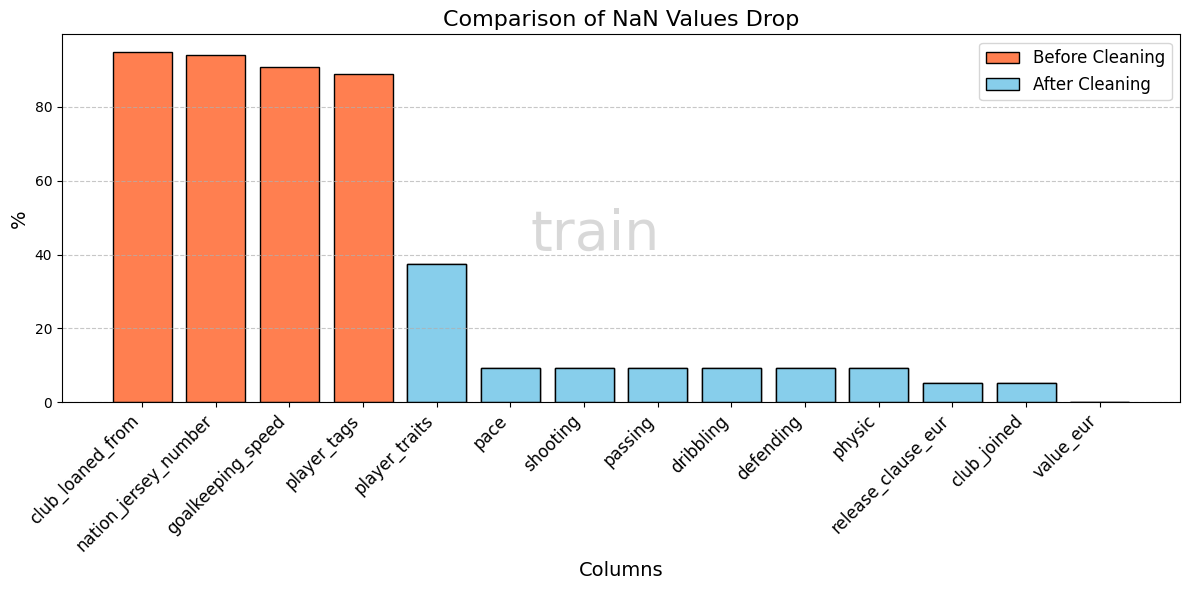

In [174]:
train_data = get_data("train")
train_data = preprocess_nan(data=train_data, dataset_type="train")


# Target column analysis

In [175]:
def plot_dist(data: pd.DataFrame, column: str) -> None:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data[column], 
        kde=True,  
        color='coral', 
        bins=30
    )
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

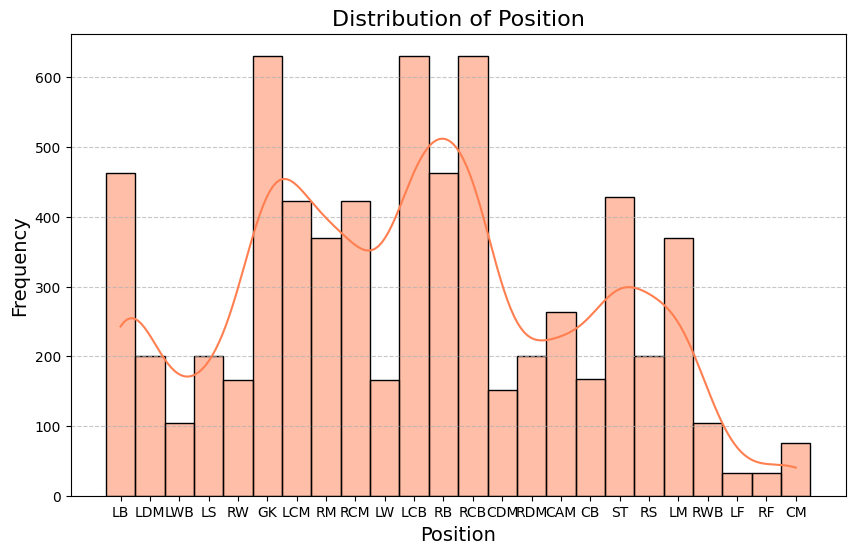

In [176]:
plot_dist(train_data, "position")

# Categorical Analysis (Not implemented fully)

In [177]:
for col in train_data.select_dtypes(include=['object', 'category']).columns:
    print(f'Categorical column {col} has {train_data[col].nunique()} unique values')

Categorical column short_name has 6692 unique values
Categorical column birthday_date has 3991 unique values
Categorical column club_name has 701 unique values
Categorical column league_name has 55 unique values
Categorical column club_joined has 1263 unique values
Categorical column nationality_name has 144 unique values
Categorical column preferred_foot has 2 unique values
Categorical column work_rate has 9 unique values
Categorical column body_type has 10 unique values
Categorical column real_face has 2 unique values
Categorical column player_traits has 772 unique values
Categorical column position has 24 unique values


In [178]:
def plot_categorical_dist(data: pd.DataFrame, n: int = 10) -> None:
    """
    Plots categorical parameters

    :param n: top n of unique values
    """
    categorical_columns = [
        col for col in data.select_dtypes(include=['object', 'category']).columns
    ]

    n_cols = 3
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(categorical_columns):
        top_categories = data[col].value_counts().head(10)

        sns.barplot(
            x=top_categories.index,
            y=top_categories.values,
            hue=top_categories.values,
            ax=axes[i],
            palette="coolwarm"
        )
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel('Category', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(len(categorical_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

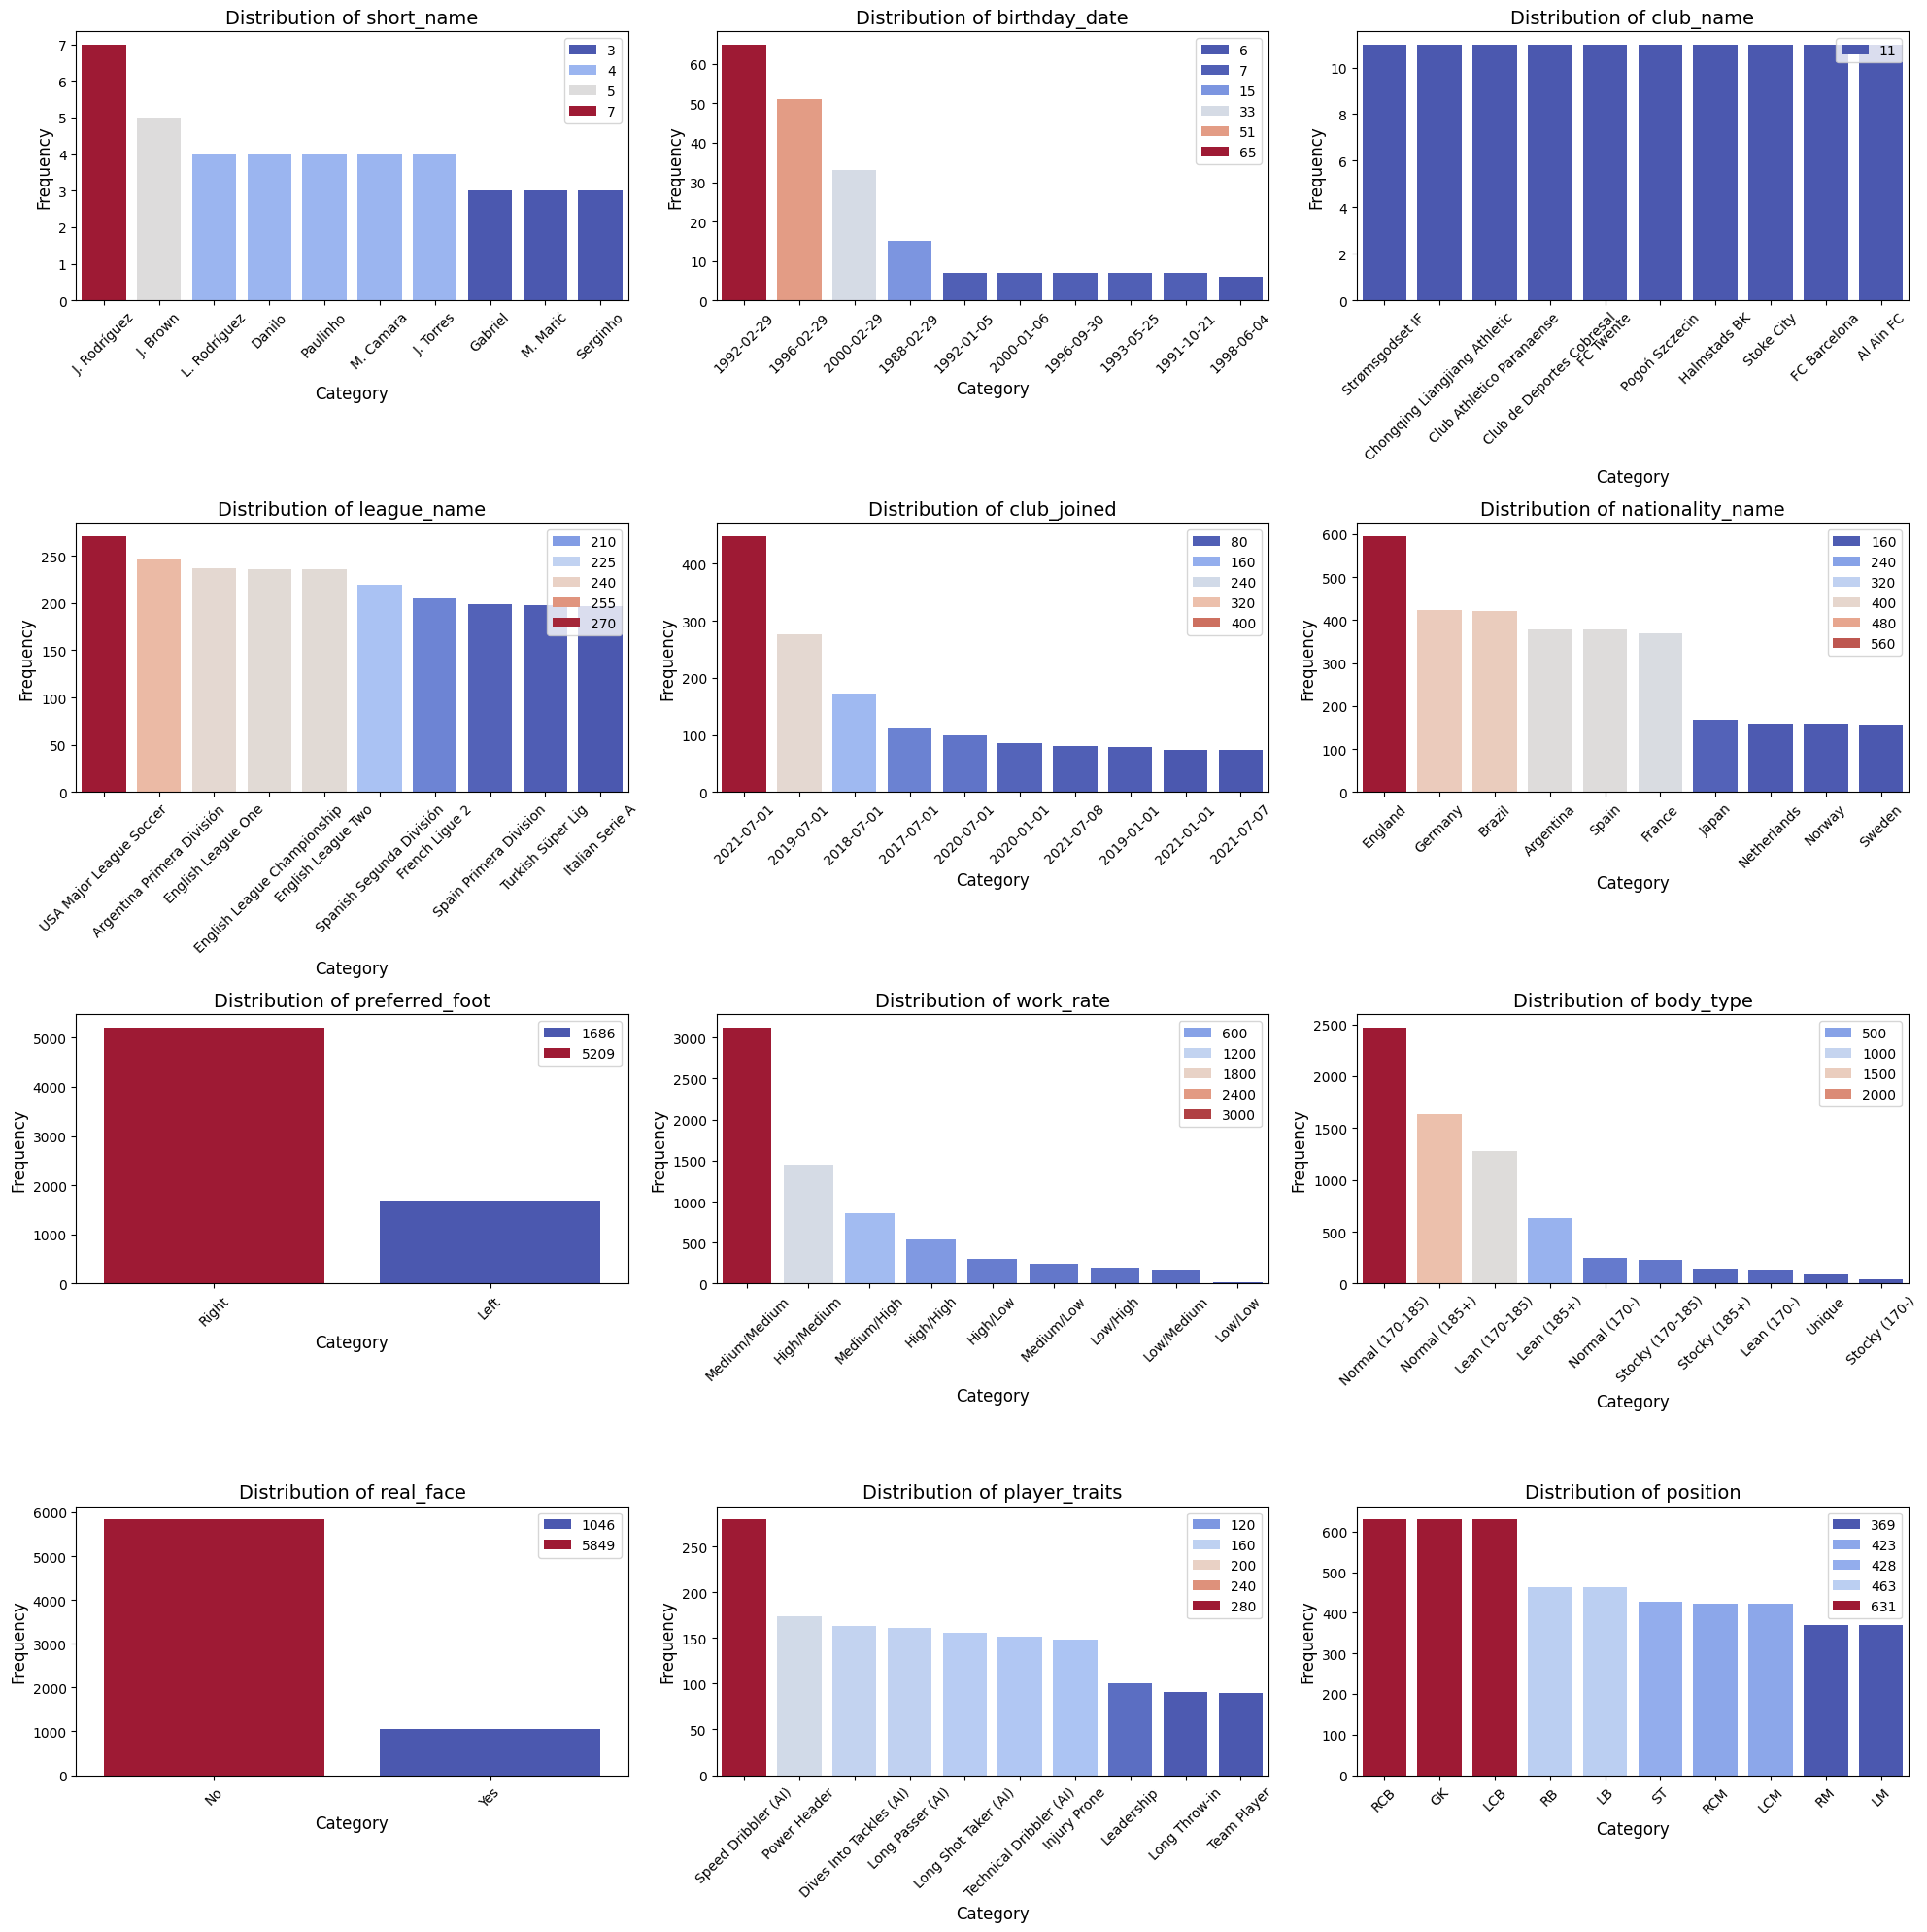

In [179]:
plot_categorical_dist(data=train_data)

# Numerical Analysis

In [180]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

train_data[numeric_columns].describe()

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,6895.000000,6895.000000,6895.000000,6.893000e+03,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,...,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000
mean,223463.552719,68.825671,72.031327,4.320388e+06,12034.126178,181.478898,75.527919,1.361856,16.442350,2022.754605,...,49.883249,61.875997,51.281653,52.249021,49.736766,15.897317,15.690210,15.558666,15.819144,16.003046
std,26876.952793,5.950459,6.070890,1.052554e+07,24630.820430,6.862683,7.041120,0.760018,15.440185,1.204310,...,15.663569,10.937084,19.654312,20.898714,20.613351,17.451010,16.752522,16.316593,17.159677,17.854369
min,41.000000,49.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,...,8.000000,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,207602.500000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,...,40.000000,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,227951.000000,68.000000,72.000000,1.400000e+06,4000.000000,182.000000,75.000000,1.000000,13.000000,2023.000000,...,50.000000,63.000000,58.000000,61.000000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,242423.500000,72.000000,76.000000,2.900000e+06,12000.000000,186.000000,80.000000,1.000000,22.000000,2024.000000,...,62.000000,69.000000,66.000000,68.000000,66.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,264481.000000,93.000000,95.000000,1.940000e+08,350000.000000,203.000000,103.000000,5.000000,99.000000,2028.000000,...,93.000000,96.000000,90.000000,93.000000,92.000000,91.000000,92.000000,91.000000,92.000000,90.000000


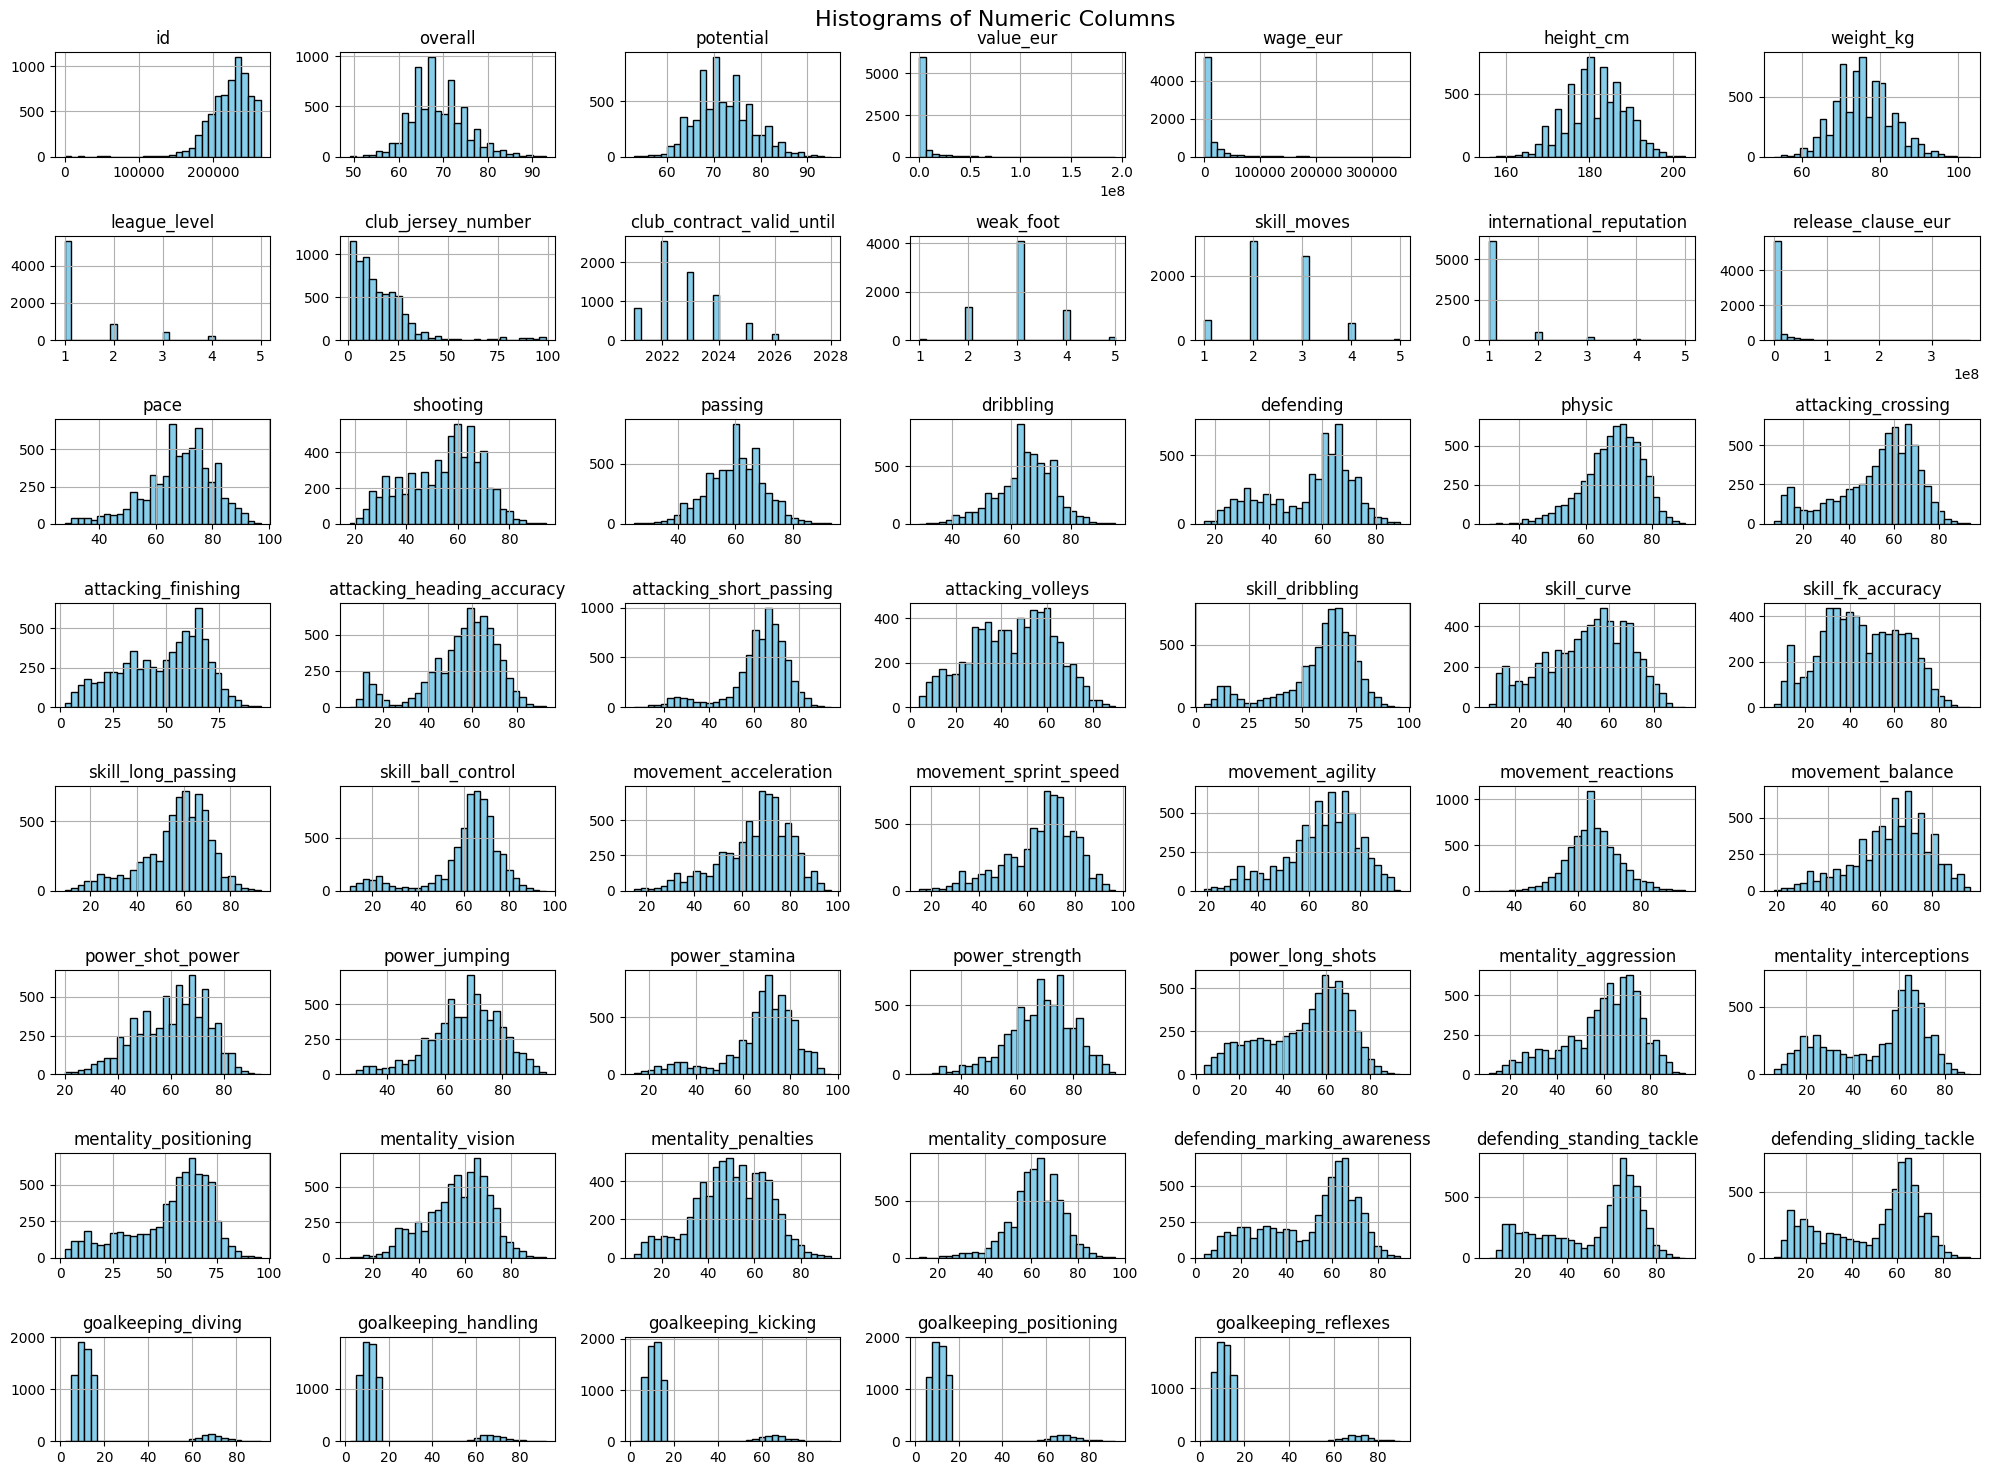

In [181]:
train_data[numeric_columns].hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

In [182]:
correlation_matrix = train_data[numeric_columns].corr()

# Since we have a lot of variables, we need to extract only those, what have high correaltion
correlation_threshold = 0.9

correlated_pairs = []

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.loc[idx, col]) > correlation_threshold:
            correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
correlated_pairs_df = correlated_pairs_df.drop_duplicates()

print("Highly correlated pairs:")
print(correlated_pairs_df)

Highly correlated pairs:
                  Feature 1                Feature 2  Correlation
0        release_clause_eur                value_eur     0.995700
1                 value_eur       release_clause_eur     0.995700
2     movement_acceleration                     pace     0.962618
3     movement_sprint_speed                     pace     0.974853
4       attacking_finishing                 shooting     0.968797
..                      ...                      ...          ...
57     goalkeeping_reflexes  goalkeeping_positioning     0.972248
58       goalkeeping_diving     goalkeeping_reflexes     0.973463
59     goalkeeping_handling     goalkeeping_reflexes     0.971948
60      goalkeeping_kicking     goalkeeping_reflexes     0.967557
61  goalkeeping_positioning     goalkeeping_reflexes     0.972248

[62 rows x 3 columns]


## Fill NaN values

### Numeric

In [183]:
def fill_nan_with_reg(data: pd.DataFrame, column: str, correlation_matrix: pd.DataFrame, corr_threshold: float = 0.8) -> pd.DataFrame:
    """
    Function fills NaN values with regression, regressors of which is highly correlated columns

    :param data: train / test
    :param column: column with NaN
    :param correaltion matrix: correlation matrix where column to be fiiled exists
    :param corr_threshold: value which is gonna be chosen for correalted variables
    """
    inital_nan = data[column].isna().sum()
    if column not in correlation_matrix.columns:
        raise ValueError(f"Column '{column}' not found in correlation matrix.")
    
    features = correlation_matrix[column][abs(correlation_matrix[column]) > corr_threshold].index.tolist()

    correlated_features = [column]
    for feature in features:
        if len(correlated_features) >= 4:
            break
        if data[feature].isna().sum() == 0:
            correlated_features.append(feature)
    
    print(correlated_features)
    
    correlated_features.remove(column)

    if not correlated_features:
        raise ValueError(f"No features with correlation above {corr_threshold} for column '{column}'.")

    print(f"Highly correlated features with '{column}': {correlated_features}")

    data_with_values = data[~data[column].isna()]
    data_with_nan = data[data[column].isna()]
    
    if data_with_values.empty:
        raise ValueError(f"No non-NaN rows found for column '{column}' to train regression model.")
    
    X = data_with_values[correlated_features]
    y = data_with_values[column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Filled {inital_nan} with R^2 score of {r2:.4f}')
    
    predicted_values = model.predict(data_with_nan[correlated_features])
    data.loc[data[column].isna(), column] = predicted_values
    
    return data[column]

In [184]:
def fill_nan_with_mean(data: pd.DataFrame, column: str) -> pd.DataFrame:
    data[column] = data[column].fillna(data[column].mean())
    
    return data[column]

In [185]:
nan_counts = train_data.isna().sum()

columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)


value_eur                2
club_joined            351
release_clause_eur     353
player_traits         2589
pace                   631
shooting               631
passing                631
dribbling              631
defending              631
physic                 631
dtype: int64


In [186]:
numeric_columns = train_data.select_dtypes(include=["float64", "int64"]).columns

for column in numeric_columns:
    if train_data[column].isna().sum() > 0:
        train_data[column] = fill_nan_with_reg(train_data.copy(), column, correlation_matrix.copy(), corr_threshold=0.8)

nan_counts = train_data.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

['value_eur', 'wage_eur']
Highly correlated features with 'value_eur': ['wage_eur']
Filled 2 with R^2 score of 0.7338
['release_clause_eur', 'value_eur', 'wage_eur']
Highly correlated features with 'release_clause_eur': ['value_eur', 'wage_eur']
Filled 353 with R^2 score of 0.9926
['pace', 'movement_acceleration', 'movement_sprint_speed']
Highly correlated features with 'pace': ['movement_acceleration', 'movement_sprint_speed']
Filled 631 with R^2 score of 0.9994
['shooting', 'attacking_finishing', 'attacking_volleys', 'power_shot_power']
Highly correlated features with 'shooting': ['attacking_finishing', 'attacking_volleys', 'power_shot_power']
Filled 631 with R^2 score of 0.9884
['passing', 'attacking_crossing', 'attacking_short_passing', 'skill_curve']
Highly correlated features with 'passing': ['attacking_crossing', 'attacking_short_passing', 'skill_curve']
Filled 631 with R^2 score of 0.9612
['dribbling', 'passing', 'skill_dribbling', 'skill_ball_control']
Highly correlated featur

### Categorical

In [187]:
train_data.head()

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,66,65,66,65,14,11,12,12,12,LB
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,59,65,61,58,10,13,7,6,11,LDM
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,65,60,58,59,10,10,8,10,11,LWB
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,75,16,22,19,16,15,13,8,9,LS
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,58,64,61,58,12,5,11,12,15,LB


# Outlier Preprocessing

In [188]:
def remove_outliers(df, method='zscore', threshold=3):
    df_cleaned = df.copy()
    numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

    if method == 'zscore':
        for col in numeric_columns:
            mean = df_cleaned[col].mean()
            std = df_cleaned[col].std()
            z_scores = (df_cleaned[col] - mean) / std
            df_cleaned = df_cleaned[np.abs(z_scores) <= threshold]
    
    elif method == 'iqr':
        for col in numeric_columns:
            q1 = df_cleaned[col].quantile(0.25)
            q3 = df_cleaned[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    else:
        raise ValueError("Method must be either 'zscore' or 'iqr'")
    
    return df_cleaned

In [189]:
before_preprocessing_length = len(train_data)

train_data = remove_outliers(train_data, "zscore", 4)

print(f'Changed from {before_preprocessing_length} to {len(train_data)}')

Changed from 6895 to 6332


# Feature Engineering

In [190]:
train_data["work_rate"]

0         Medium/High
1       Medium/Medium
2         High/Medium
3         High/Medium
4         Medium/High
            ...      
6889      High/Medium
6890    Medium/Medium
6892      High/Medium
6893      Medium/High
6894    Medium/Medium
Name: work_rate, Length: 6332, dtype: object

In [191]:
def delete_high_corr(data: pd.DataFrame, threshold: float = 0.9) -> pd.DataFrame:
    """
    Удаляет колонки с высокой корреляцией из DataFrame, учитывая только числовые колонки,
    и выводит информацию об удаленных колонках.

    :param data: Входной DataFrame
    :param threshold: Пороговое значение корреляции для удаления колонок
    :return: DataFrame без высоко коррелированных колонок
    """
    import numpy as np

    numeric_cols = data.select_dtypes(include=[np.number]).columns

    corr_matrix = data[numeric_cols].corr().abs()

    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Deleted {len(to_drop)} columns with corr > {threshold}:")
    for col in to_drop:
        print(f"- {col}")

    data_reduced = data.drop(columns=to_drop)

    return data_reduced

In [192]:
def tranform_age(data: pd.DataFrame, input_column: str, output: str, age_type: str) -> pd.DataFrame:
    data[input_column] = pd.to_datetime(data[input_column])

    data[output] = pd.Timestamp.now().year - data[input_column].dt.year

    data.drop(columns=[input_column], inplace=True)

    return data

In [193]:
def split_height_and_type(column):
    height = column.str.extract(r'\((\d+[-\+]\d*)\)')[0]
    body_type = column.str.extract(r'^(\w+)')[0]
    return height, body_type

In [194]:
def preprocess_features(data: pd.DataFrame) -> pd.DataFrame:
    data = tranform_age(data=data, input_column="birthday_date", output="age", age_type="birthday")

    data = tranform_age(data=data, input_column="club_joined", output="club_age", age_type="club")

    _, data["body_type_cleaned"] = split_height_and_type(data["body_type"])

    data = data.drop(columns=["body_type"])

    return data

In [195]:
print(train_data.isnull().sum())

train_data = preprocess_features(train_data.copy())

print(train_data.isnull().sum())

train_data["club_age"]

id                         0
short_name                 0
overall                    0
potential                  0
value_eur                  0
                          ..
goalkeeping_handling       0
goalkeeping_kicking        0
goalkeeping_positioning    0
goalkeeping_reflexes       0
position                   0
Length: 66, dtype: int64
id                        0
short_name                0
overall                   0
potential                 0
value_eur                 0
                       ... 
goalkeeping_reflexes      0
position                  0
age                       0
club_age                328
body_type_cleaned         0
Length: 66, dtype: int64


0       3.0
1       3.0
2       3.0
3       6.0
4       5.0
       ... 
6889    5.0
6890    3.0
6892    4.0
6893    9.0
6894    3.0
Name: club_age, Length: 6332, dtype: float64

# Categorical Encoding

In [196]:
from sklearn.preprocessing import LabelEncoder

def label_encode(column: pd.Series):
    le = LabelEncoder()

    return le.fit_transform(column)

In [197]:
def transform_cat_to_num(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    le = LabelEncoder()
    for column in columns:
        if column in data.columns and column != "position":
            print(f'Tranforming {column} ({len(data[column].unique())} unique values) to label columns')
            data[column] = le.fit_transform(data[column])

    return data

### Dropping columns

In [198]:
train_data = train_data.drop(columns=["player_traits", "nationality_name", "club_name", "short_name", "league_name", "id"])

In [199]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

train_data = transform_cat_to_num(train_data, categorical_columns)

Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns


In [200]:
train_data.head()

,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,preferred_foot,...,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position,age,club_age,body_type_cleaned
0,71,71,1400000.0,10000,176,73,1,29,2026,1,...,65,14,11,12,12,12,LB,35,3.0,1
1,65,71,1000000.0,2000,183,73,1,4,2022,1,...,58,10,13,7,6,11,LDM,28,3.0,0
2,65,77,1600000.0,2000,178,69,1,19,2026,0,...,59,10,10,8,10,11,LWB,23,3.0,1
3,72,72,2300000.0,5000,188,81,1,9,2023,1,...,19,16,15,13,8,9,LS,32,6.0,0
4,65,65,525000.0,3000,179,74,1,30,2022,0,...,58,12,5,11,12,15,LB,34,5.0,1


# Building pipeline function

In [201]:
def preprocess_data(data: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    # Drop those columns that have to many nan values
    data = preprocess_nan(data=data, dataset_type=dataset_type, plot=False)
    
    # Remove outliers
    # data = remove_outliers(data, "zscore", 4)

    # Generate Features
    data = preprocess_features(data)

    data = transform_cat_to_num(data, data.select_dtypes(include=['object']).columns)

    data = data.drop(
        columns=[
            "player_traits", 
            "nationality_name", 
            "club_name", 
            "short_name", 
            "league_name", 
            "club_contract_valid_until",
            "club_jersey_number",
            "id",
            "real_face",
            "club_age",
        ]
    )
    
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

    # Fill nan values
    for column in numeric_columns:
        if data[column].isna().sum() > 0:
            try:
                data[column] = fill_nan_with_mean(data.copy(), column)
                # data[column] = fill_nan_with_reg(data.copy(), column, correlation_matrix.copy(), corr_threshold=0.8)
            except Exception as e:
                print(e)

    data = delete_high_corr(data)

    return data
    

In [202]:
train_data = get_data("train")

initial_columns = train_data.columns

In [203]:
train_data = preprocess_data(train_data, "train")

deleted_columns = []
for column in initial_columns:
    if column not in train_data.columns:
        deleted_columns.append(column)

print(f'Deleted columns: {deleted_columns}')
train_data.shape

Tranforming short_name (6692 unique values) to label columns
Tranforming club_name (701 unique values) to label columns
Tranforming league_name (55 unique values) to label columns
Tranforming nationality_name (144 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (773 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Удалено 11 колонок с корреляцией выше 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_positioning
- defending_marking_awareness
- defending_standing_tackle
- defending_sliding_tackle
- goalkeeping_handling
- goalkeeping_kicking
- goalkeeping_positioning
- goalkeeping_reflexes
Deleted columns: ['id', 'short_name', 'birthday_date', 'club_name', 'league_name', 'club_jersey_number', 'club_loaned_from', 'club_joined'

(6895, 45)

In [204]:
train_data.shape

(6895, 45)

# Building model / Testing

In [205]:
X = train_data.drop("position", axis=1)
y = train_data["position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=12, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred, average="weighted")

print(f1) 

rf.feature_importances_

0.39876352120091824


array([0.01010759, 0.01040279, 0.01215858, 0.01079333, 0.020311  ,
       0.01575483, 0.0024703 , 0.03844983, 0.00372459, 0.02374617,
       0.00093201, 0.00845801, 0.02784575, 0.03823948, 0.0187244 ,
       0.01764492, 0.06928247, 0.01670554, 0.04535689, 0.05881894,
       0.04705742, 0.01900105, 0.02972657, 0.03095013, 0.01903078,
       0.01868212, 0.02580615, 0.02643718, 0.0175185 , 0.01092747,
       0.01659076, 0.01223416, 0.0156472 , 0.02213025, 0.02580047,
       0.02980124, 0.01818035, 0.06937097, 0.0254854 , 0.01859378,
       0.01221664, 0.02460395, 0.01127149, 0.00300854])

In [206]:
test_data = get_data("test")

ids = test_data["id"]

test_data = preprocess_data(test_data, "test")

rf.fit(X_train, y_train)

predictions = rf.predict(test_data)
output_df = pd.DataFrame({'id': ids, 'position': predictions})
output_df.to_csv('submission.csv', index=False)

Tranforming short_name (764 unique values) to label columns
Tranforming club_name (488 unique values) to label columns
Tranforming league_name (52 unique values) to label columns
Tranforming nationality_name (82 unique values) to label columns
Tranforming preferred_foot (2 unique values) to label columns
Tranforming work_rate (9 unique values) to label columns
Tranforming real_face (2 unique values) to label columns
Tranforming player_traits (194 unique values) to label columns
Tranforming body_type_cleaned (4 unique values) to label columns
Удалено 11 колонок с корреляцией выше 0.9:
- release_clause_eur
- skill_ball_control
- movement_sprint_speed
- mentality_positioning
- defending_marking_awareness
- defending_standing_tackle
- defending_sliding_tackle
- goalkeeping_handling
- goalkeeping_kicking
- goalkeeping_positioning
- goalkeeping_reflexes


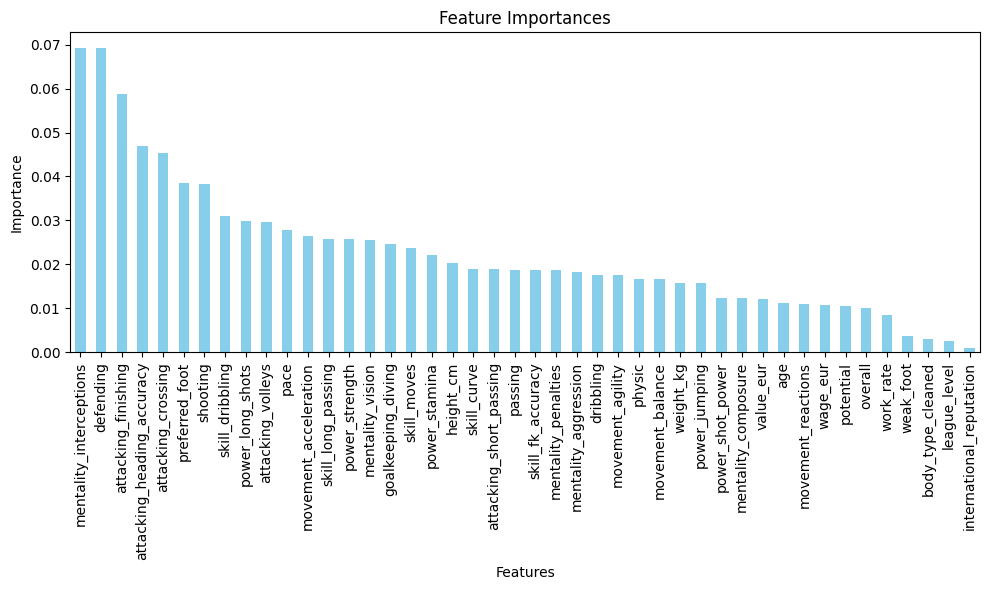

In [207]:
feature_importances = rf.feature_importances_
important_features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
important_features.plot(kind='bar', color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [208]:
train_data.isnull().sum()

overall                       0
potential                     0
value_eur                     0
wage_eur                      0
height_cm                     0
weight_kg                     0
league_level                  0
preferred_foot                0
weak_foot                     0
skill_moves                   0
international_reputation      0
work_rate                     0
pace                          0
shooting                      0
passing                       0
dribbling                     0
defending                     0
physic                        0
attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
attacking_short_passing       0
attacking_volleys             0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_long_passing            0
movement_acceleration         0
movement_agility              0
movement_reactions            0
movement_balance              0
power_sh

Best configurations by F1 Score:
({'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 200}, 0.39876352120091824)
({'criterion': 'gini', 'max_depth': 18, 'n_estimators': 200}, 0.3973402537208147)
({'criterion': 'entropy', 'max_depth': 18, 'n_estimators': 200}, 0.3962678455698656)
({'criterion': 'gini', 'max_depth': 14, 'n_estimators': 200}, 0.39332259559417626)
({'criterion': 'gini', 'max_depth': 16, 'n_estimators': 100}, 0.3931501397048601)


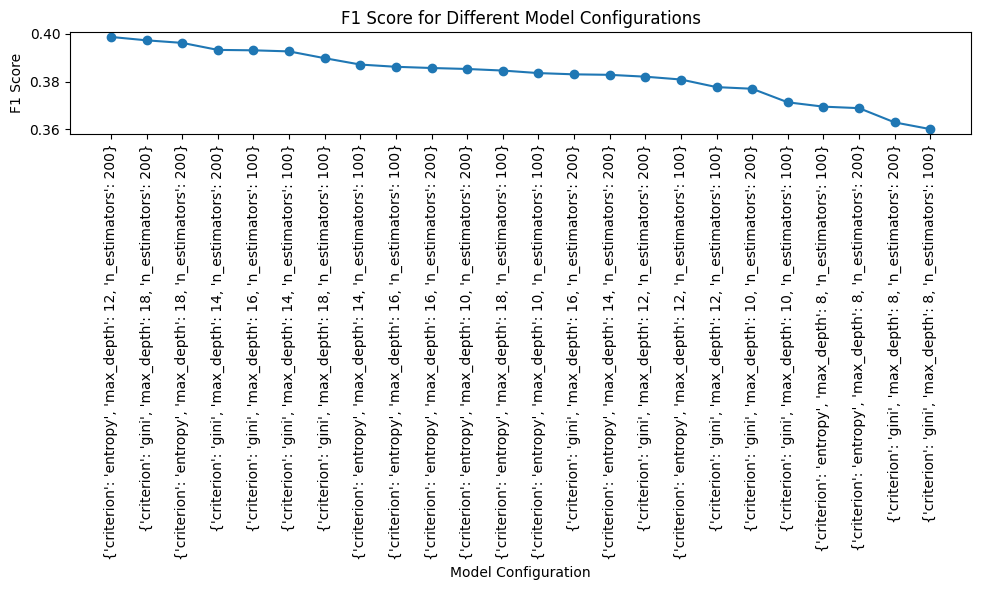

In [209]:
from sklearn.model_selection import train_test_split, ParameterGrid

param_grid = {
    'n_estimators': [i for i in range(100,300,100)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(8,20,2)]
}

grid = ParameterGrid(param_grid)
results = []

for params in grid:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((params, f1))

results = sorted(results, key=lambda x: x[1], reverse=True)

print("Best configurations by F1 Score:")
for res in results[:5]:
    print(res)

params_list = [str(res[0]) for res in results]
f1_scores = [res[1] for res in results]

plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores)), f1_scores, marker='o')
plt.xticks(range(len(params_list)), params_list, rotation=90)
plt.xlabel('Model Configuration')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Model Configurations')
plt.tight_layout()
plt.show()